In [2]:
import numpy as np
import pandas as pd

xls = pd.ExcelFile("data.xlsx")

dzip = xls.parse('dzip', header=None).values.flatten()       
azip = xls.parse('azip', header=None).values                 

dtest = xls.parse('dtest', header=None).values.flatten()     
testzip = xls.parse('testzip', header=None).values           


C:\Users\vagge\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\vagge\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\vagge\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\vagge\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [3]:
from numpy.linalg import svd

digit_classes = np.unique(dzip)

# Group training images by digit
class_data = {digit: azip[:, dzip == digit] for digit in digit_classes}

# Compute SVD for each class
svd_bases = {}
svd_values = {}
for digit in digit_classes:
    U, S, Vt = svd(class_data[digit], full_matrices=False)
    svd_bases[digit] = U  
    svd_values[digit] = S  


In [4]:
from numpy.linalg import lstsq, norm

def classify_digit(x, k):
    best_digit = None
    best_residual = float('inf')
    for digit in digit_classes:
        Uk = svd_bases[digit][:, :k] 
        coeffs, _, _, _ = lstsq(Uk, x, rcond=None)
        residual = norm(x - Uk @ coeffs) / norm(x)
        if residual < best_residual:
            best_residual = residual
            best_digit = digit
    return best_digit


k = 5, Accuracy = 0.9028
k = 6, Accuracy = 0.9053
k = 7, Accuracy = 0.9168
k = 8, Accuracy = 0.9203
k = 9, Accuracy = 0.9263
k = 10, Accuracy = 0.9317
k = 11, Accuracy = 0.9322
k = 12, Accuracy = 0.9357
k = 13, Accuracy = 0.9362
k = 14, Accuracy = 0.9392
k = 15, Accuracy = 0.9412
k = 16, Accuracy = 0.9387
k = 17, Accuracy = 0.9392
k = 18, Accuracy = 0.9417
k = 19, Accuracy = 0.9407
k = 20, Accuracy = 0.9397


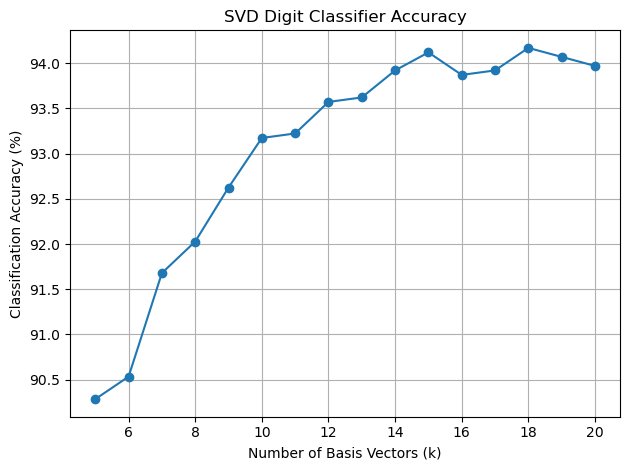

In [5]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

ks = range(5, 21)
accuracies = []

for k in ks:
    predictions = [classify_digit(x, k) for x in testzip.T]
    acc = accuracy_score(dtest, predictions)
    accuracies.append(acc)
    print(f"k = {k}, Accuracy = {acc:.4f}")

plt.plot(ks, [a * 100 for a in accuracies], marker='o')
plt.xlabel("Number of Basis Vectors (k)")
plt.ylabel("Classification Accuracy (%)")
plt.title("SVD Digit Classifier Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


Digit 0: Accuracy = 0.9889
Digit 1: Accuracy = 0.9848
Digit 2: Accuracy = 0.9040
Digit 3: Accuracy = 0.8916
Digit 4: Accuracy = 0.9300
Digit 5: Accuracy = 0.8750
Digit 6: Accuracy = 0.9529
Digit 7: Accuracy = 0.9592
Digit 8: Accuracy = 0.9217
Digit 9: Accuracy = 0.9322


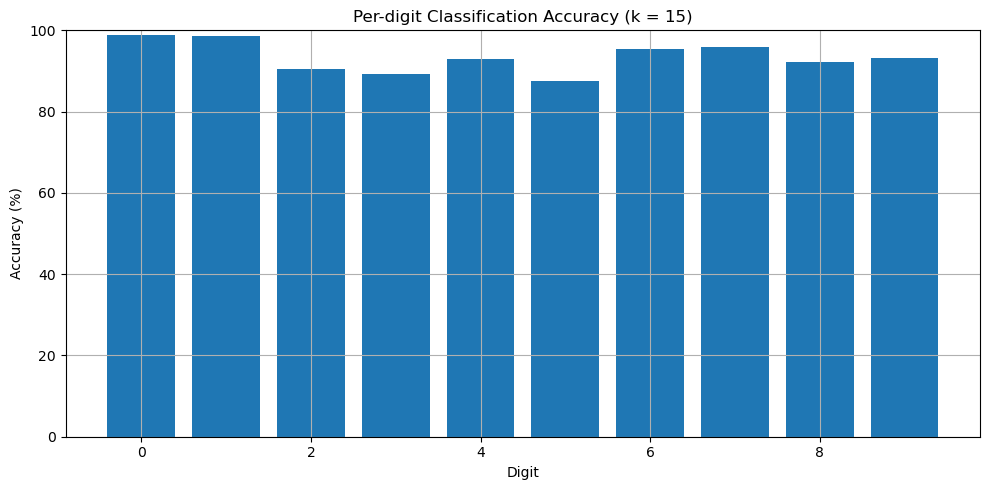

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

k_fixed = 15
preds = [classify_digit(x, k_fixed) for x in testzip.T]

# Compute confusion matrix and per-digit accuracy
conf_mat = confusion_matrix(dtest, preds, labels=digit_classes)
per_digit_acc = conf_mat.diagonal() / conf_mat.sum(axis=1)

for digit, acc in zip(digit_classes, per_digit_acc):
    print(f"Digit {digit}: Accuracy = {acc:.4f}")

plt.figure(figsize=(10, 5))
plt.bar(digit_classes, per_digit_acc * 100)
plt.xlabel("Digit")
plt.ylabel("Accuracy (%)")
plt.title(f"Per-digit Classification Accuracy (k = {k_fixed})")
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
adaptive_k = {}
for digit in digit_classes:
    s = svd_values[digit]
    energy = np.cumsum(s ** 2) / np.sum(s ** 2)
    k_needed = np.searchsorted(energy, 0.9) + 1  # retain 90% energy
    adaptive_k[digit] = k_needed

print("Adaptive k per digit:")
for digit in digit_classes:
    print(f"Digit {digit}: k = {adaptive_k[digit]}")

def classify_digit_adaptive(x, k_dict):
    best_digit = None
    best_residual = float('inf')
    for digit in digit_classes:
        Uk = svd_bases[digit][:, :k_dict[digit]]
        coeffs, _, _, _ = lstsq(Uk, x, rcond=None)
        residual = norm(x - Uk @ coeffs) / norm(x)
        if residual < best_residual:
            best_residual = residual
            best_digit = digit
    return best_digit

adaptive_preds = [classify_digit_adaptive(x, adaptive_k) for x in testzip.T]
adaptive_acc = accuracy_score(dtest, adaptive_preds)

print(f"\nAccuracy using adaptive k per class: {adaptive_acc:.4f}")


Adaptive k per digit:
Digit 0: k = 15
Digit 1: k = 1
Digit 2: k = 28
Digit 3: k = 18
Digit 4: k = 17
Digit 5: k = 19
Digit 6: k = 12
Digit 7: k = 9
Digit 8: k = 19
Digit 9: k = 9

Accuracy using adaptive k per class: 0.9088
